### Informações sobre atributos:
1) __id__: identificador único
2) __gênero__: "Masculino", "Feminino" ou "Outro"
3) __idade__: idade do paciente
4) __hipertensão__: 0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão
5) __doença cardíaca__: 0 se o paciente não tiver doença cardíaca, 1 se o paciente tiver doença cardíaca
6) __já casado__: "Não" ou "Sim"
7) __tipo de trabalho__: "crianças"(`children`), "Funcionário público"(`Govt_jov`), "Nunca trabalhou"(`Never_worked`), "Privado"(`Private`) ou "Autônomo"(`Self-employed`)
8) __tipo de residência__: "Rural" ou "Urbana"
9) __nível médio de glicose__: nível médio de glicose no sangue
10) __IMC__: índice de massa corporal
11) __status de tabagismo__: "ex-fumante"(`formerly smoked`), "nunca fumou"(`formerly smoked`), "fuma"(`smokes`) ou "Desconhecido"(`Unknown`)
12) __AVC__: 1 se o paciente teve um AVC ou 0 se não teve

In [87]:
import copy 
import pandas as pd
import seaborn as sea 
import matplotlib.pyplot as plt

In [88]:
data = pd.read_csv(r'datasets/StrokePredictionDataset/healthcare-dataset-stroke-data.csv',sep=',')

In [89]:
data.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


## Analise dos dados

In [90]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


> Nesse conjunto de daddos para valores númericos continuos irei fazer a padronização dos dados

In [91]:
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

> quantidade de valores unicos de cada atributo

In [92]:
valoresNulos = (pd.concat([data.isna().nunique(),data.isnull().nunique()] ,axis=1))
valoresNulos.columns = ['NaN','NULL']
valoresNulos

,NaN,NULL
id,1,1
gender,1,1
age,1,1
hypertension,1,1
heart_disease,1,1
ever_married,1,1
work_type,1,1
Residence_type,1,1
avg_glucose_level,1,1
bmi,2,2


In [93]:
data.drop(index = data.loc[data['bmi'].isna()==True].index , inplace=True)

> Verifiquei em cada atributo se possui valores Nulos, tornando cada valor em um boleano e depois verifiquei a quantidade de valores únicos assim para atributos com 2 possui valores nulos. Será removido a valores null

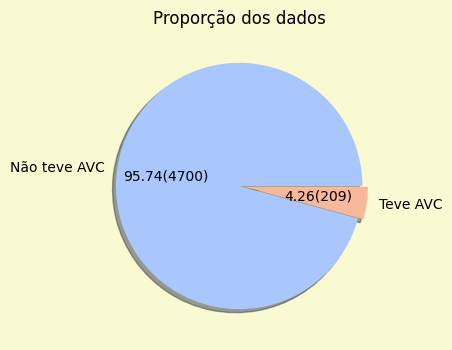

In [118]:
pizza = data['stroke'].value_counts()

plt.figure(figsize=(6,4),facecolor='#FAFAD2')
plt.pie(x=pizza.values , labels= ['Não teve AVC','Teve AVC'] , autopct = lambda x:'{:.2f}({:.0f})'.format(x,((x*pizza.sum())/100)) , colors=sea.color_palette('coolwarm',n_colors=2),shadow=True,explode=(0,0.045),pctdistance=0.6)
plt.title('Proporção dos dados')
plt.show()

> No preprocessamento dos dados para a classificação se faz necessario o balanceamento dos dados , a mais valores para pessoas que não teve Avc para as que tiveram

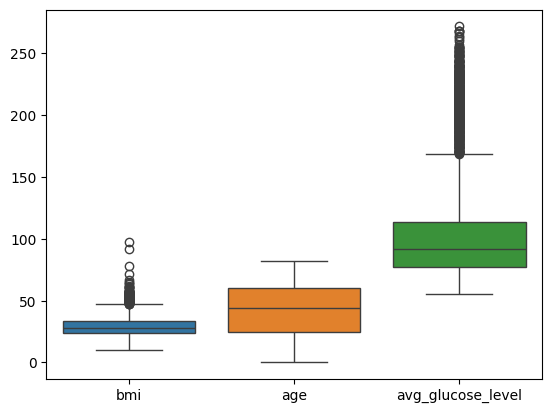

In [115]:
sea.boxplot( data[['bmi','age','avg_glucose_level']])
plt.show()

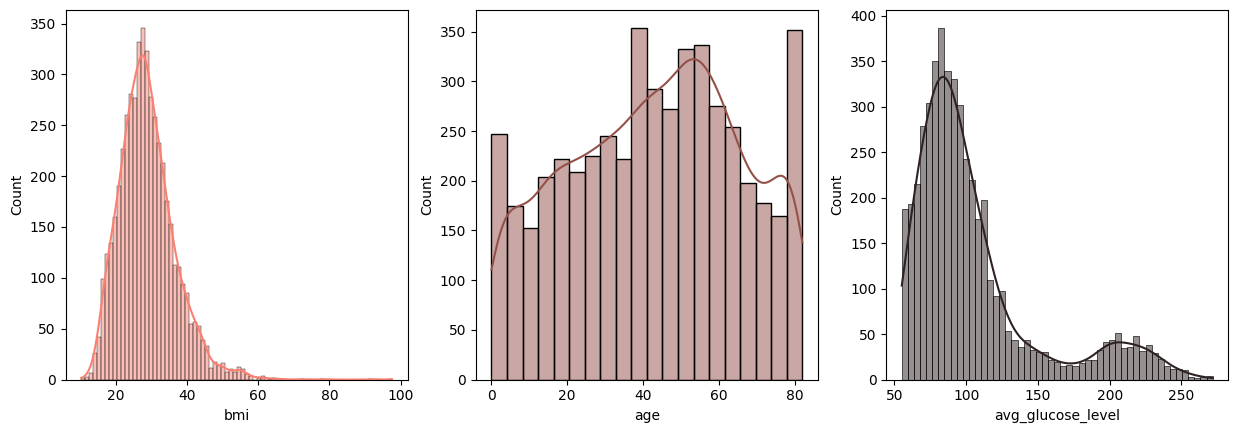

In [168]:
fig , ax = plt.subplots(1,3)
fig.set_figwidth(15)
colors   = sea.color_palette('dark:salmon_r',n_colors=3)
index    = 0
for coluna in ['bmi','age','avg_glucose_level']:
    sea.histplot(data[coluna], ax=ax[index] ,color=colors[index] , kde=True); index +=1
plt.show()

> Há outlier

/tmp/ipykernel_4128/2170960526.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hist  = hist.groupby(by=['bmi'])['stroke'].value_counts().reset_index()


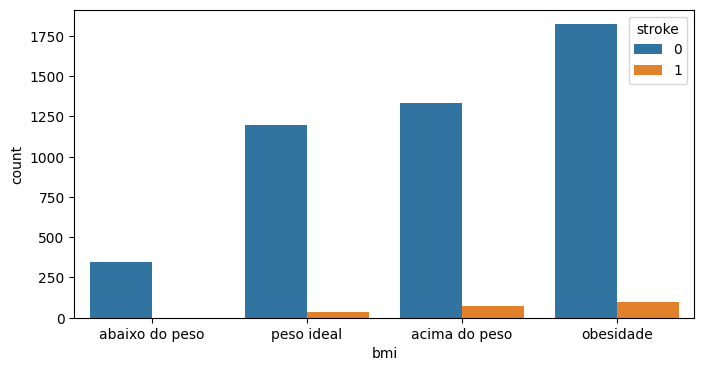

In [170]:
bin   = [min(data['bmi']),18.5,24.9,29.9,max(data['bmi'])]
label = ['abaixo do peso','peso ideal','acima do peso','obesidade']
freq  = pd.cut(x = data['bmi'] , bins=bin ,labels=label)
hist  = pd.concat([freq,data[['stroke']]],axis=1)
hist  = hist.groupby(by=['bmi'])['stroke'].value_counts().reset_index()
plt.figure(figsize=(8,4))
sea.barplot(x = hist['bmi'] ,y=hist['count'],hue=hist['stroke'])
plt.show()

In [183]:
data['gender'].value_counts().reset_index()

,gender,count
0,Female,2897
1,Male,2011
2,Other,1


In [184]:
data.drop( index = data.loc[data['gender']=='Other'].index , inplace=True)

> No atributo `gender` o valores other só aparece uma vez , será removido

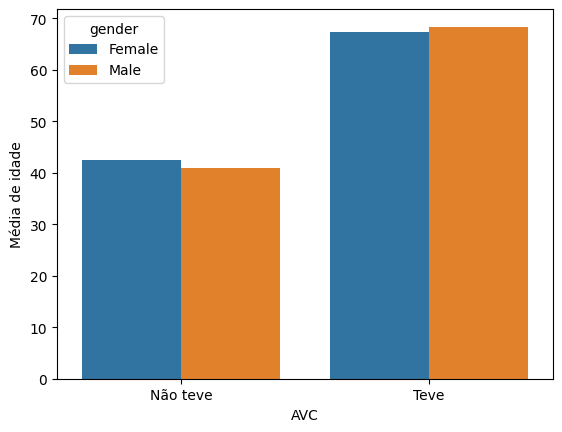

In [196]:
resultado = data.groupby(by=['gender','stroke'])['age'].mean().reset_index()

sea.barplot(x = resultado['stroke'] , y=resultado['age'] ,hue = resultado['gender'])
plt.xticks([0,1],['Não teve','Teve'])
plt.ylabel('Média de idade')
plt.xlabel('AVC')
plt.show()